In [1]:
import pandas as pd

df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_median_centered.csv",index_col=0)

clinical_df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_clinical_metadata_cleaned.csv", index_col=0)

# Set title as index
clinical_df_indexed = clinical_df.set_index("title")

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


In [2]:
# Shows columns with any NaNs and how many there are
na_cols = df.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


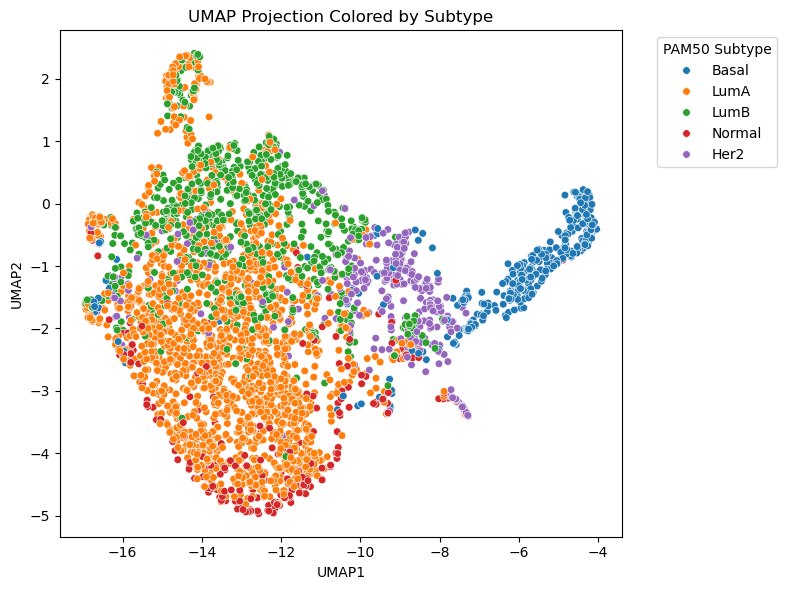

Adjusted Rand Index (UMAP + KMeans): 0.240


In [3]:
# UMAP Visualization of Gene Expression
# -------------------------------------
# Required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


# Optional: rename long GEO column name
clinical_df_indexed = clinical_df_indexed.rename(columns={"characteristics_ch1.20.pam50 subtype": "pam50_subtype"})

# --- PCA preprocessing before UMAP ---
pca = PCA(n_components=50)
X_pca = pca.fit_transform(df)

# --- UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Create DataFrame for plotting ---

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=expression_df.index)
umap_df = umap_df.join(clinical_df_indexed)  # This has "pam50_subtype" indexed correctly


# --- Plot UMAP by subtype ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP Projection Colored by Subtype")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Optional: K-Means clustering on UMAP ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(X_umap)

# Drop rows where either subtype or cluster is NaN
umap_df_clean = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

# Compute ARI only on complete cases
ari = adjusted_rand_score(umap_df_clean["pam50_subtype"], umap_df_clean["Cluster"])
print(f"Adjusted Rand Index (UMAP + KMeans): {ari:.3f}")
